# KF EM RTS Nomoto

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.kalman_filter import filter_yaw, rts_smoother

import src.visualization.book_format as book_format
book_format.set_style()

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
def simulate(Ad, Bd, E, ws, t, us):

    simdata = []
    x_ = np.deg2rad(np.array([[0, 0]]).T)
    for u_, w_ in zip(us, ws):

        x_ = (Ad @ x_ + Bd * u_) + E * w_

        simdata.append(x_.flatten())

    simdata = np.array(simdata)
    df = pd.DataFrame(simdata, columns=["psi", "r"], index=t)
    df["delta"] = us

    return df


def do_simulation(h, Ad, Bd):
    ## Simulate
    N = 4000
    t_ = np.arange(0, N * h, h)

    us = np.deg2rad(
        np.concatenate(
            (
                -10 * np.ones(int(N / 4)),
                10 * np.ones(int(N / 4)),
                -10 * np.ones(int(N / 4)),
                10 * np.ones(int(N / 4)),
            )
        )
    )

    E = np.array([[0, 1]]).T
    process_noise = np.deg2rad(0.01)
    ws = process_noise * np.random.normal(size=N)
    df = simulate(Ad=Ad, Bd=Bd, E=E, ws=ws, t=t_, us=us)

    measurement_noise = np.deg2rad(3)
    df["epsilon"] = measurement_noise * np.random.normal(size=N)
    df["psi_measure"] = df["psi"] + df["epsilon"]
    df["psi_deg"] = np.rad2deg(df["psi"])
    df["psi_measure_deg"] = np.rad2deg(df["psi_measure"])
    df["delta_deg"] = np.rad2deg(df["delta"])
    return df

In [3]:
np.random.seed(42)

T_1 = 1.8962353076056344
K = 0.17950970687951323
h = 0.02

Ad = np.array([[1, h], 
               [0, 1 - h / T_1]])
Bd = np.array([[0, -K * h / T_1]]).T
df = do_simulation(h=h, Ad=Ad, Bd=Bd)

In [4]:
T_1 = 2.8962353076056344  # Note
K = 0.17950970687951323

Ad = np.array([[1, h], 
               [0, 1 - h / T_1]])
Bd = np.array([[0, -K * h / T_1]]).T

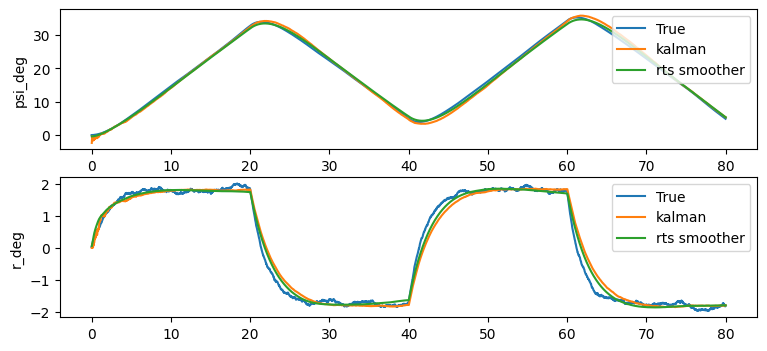

In [5]:
x0 = np.deg2rad(np.array([[0, 0]]).T)
P_prd = np.deg2rad(np.array([
    [1, 0],
    [0., 0.1],
]))

Qd = np.deg2rad(np.diag([0, 0.1]))

Rd = np.deg2rad(0.1)

ys = df["psi_measure"].values
us = df["delta"].values

E_ = np.array(
    [[0, 0], 
     [0, 1]],
)

C_ = np.array([[1, 0]])

Cd_ = C_
Ed_ = h * E_

time_steps = filter_yaw(
    x0=x0,
    P_prd=P_prd,
    h_m=h,
    h=h,
    us=us,
    ys=ys,
    Ad=Ad,
    Bd=Bd,
    Cd=Cd_,
    Ed=Ed_,
    Qd=Qd,
    Rd=Rd,
)
x_hats = np.array([time_step["x_hat"] for time_step in time_steps])
P_hats = [time_step["P_hat"] for time_step in time_steps]
time = np.array([time_step["time"] for time_step in time_steps]).T
x, P, K, Pp = rts_smoother(x_hats=x_hats, P_hats=P_hats, Ad=Ad, Bd=Bd, Qd=Qd, us=us)

n = len(P_prd)
fig, axes = plt.subplots(nrows=n)

df["psi_measure_deg"] = np.rad2deg(df["psi_measure"])
df["psi_deg"] = np.rad2deg(df["psi"])
df["r_deg"] = np.rad2deg(df["r"])


keys = ["psi_deg", "r_deg"]
for i, key in enumerate(keys):

    ax = axes[i]
    df.plot(y=key, ax=ax, label="True")
    
    if key == "psi":
        df.plot(y="psi_measure_deg", ax=ax, label="Measured", zorder=-1)

    ax.plot(time, np.rad2deg(x_hats[:, i]), "-", label="kalman")
    ax.plot(time, np.rad2deg(x[:, i]), "-", label="rts smoother")
    ax.set_ylabel(key)
    ax.legend(loc='upper right')

In [6]:
from scipy.stats import multivariate_normal

In [7]:
x_hats.shape

(4000, 2)

In [8]:
np.max(x_hats,axis=0)

array([0.625, 0.032])

In [9]:
x_mins = np.min(x_hats,axis=0)
x_maxs = np.max(x_hats,axis=0)

n_grid = 100
psis = np.linspace(x_mins[0],x_maxs[0],n_grid)
rs = np.linspace(x_mins[1],x_maxs[1],n_grid)

Psis, Rs = np.meshgrid(psis, rs)
pos = np.dstack((Psis, Rs))

In [10]:
N_ = len(x_hats)
times = 10
n = int(N_/times)
covs = P[::n]
#covs = P_hats[::n]
means = x_hats[::n]
time_ = time[::n]


f_all = np.zeros((n_grid,n_grid))
for mean, cov in zip(means, covs):
    
    rv = multivariate_normal(mean=mean, cov=cov)
    f = rv.pdf(pos)
    f_all+=f
    
    
    

Text(0, 0.5, '$r$')

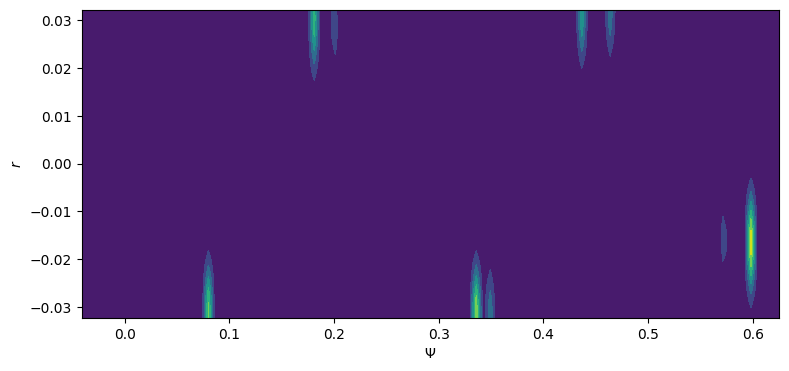

In [11]:
fig,ax=plt.subplots()
ax.contourf(psis, rs, f_all)
ax.set_xlabel(r'$\Psi$')
ax.set_ylabel(r'$r$')

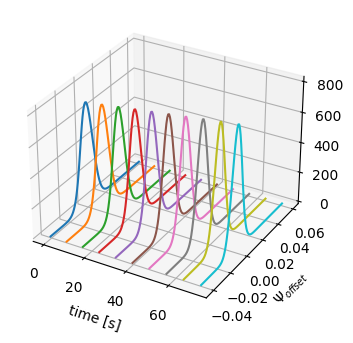

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for mean, cov, t_ in zip(means, P, time_):
    
    rv = multivariate_normal(mean=[0,0], cov=cov)
       
    psis = np.linspace(np.min(means[:,0]),0.1*np.max(means[:,0]),100)
    pos = np.zeros((len(psis),2))
    pos[:,0] = psis
    
    f = rv.pdf(pos)
    
    ax.plot(t_*np.ones(len(psis)),psis,f)

ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\Psi_{offset}$');


        
    

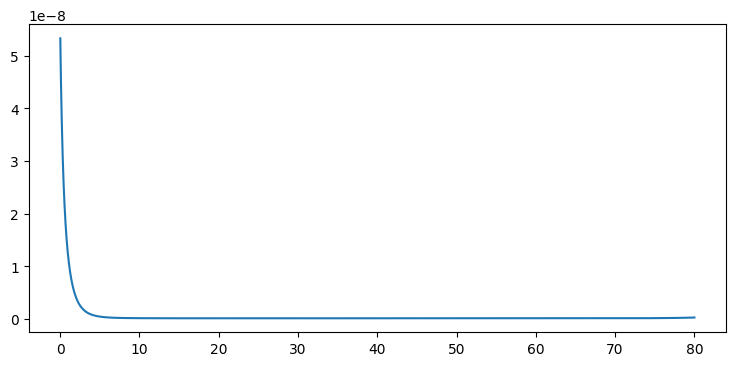

In [13]:
from numpy.linalg import det
d = [det(P_) for P_ in P]

fig,ax=plt.subplots()
ax.plot(time, d)

In [14]:
def filter(Ad, Bd):
    
    x0 = np.deg2rad(np.array([[0, 0]]).T)
    P_prd = np.deg2rad(np.array([
        [1, 0],
        [0., 0.1],
    ]))
    
    Qd = np.deg2rad(np.diag([0, 0.1]))
    
    Rd = np.deg2rad(0.1)
    
    ys = df["psi_measure"].values
    us = df["delta"].values
    
    E_ = np.array(
        [[0, 0], 
         [0, 1]],
    )
    
    C_ = np.array([[1, 0]])
    
    Cd_ = C_
    Ed_ = h * E_
    
    time_steps = filter_yaw(
        x0=x0,
        P_prd=P_prd,
        h_m=h,
        h=h,
        us=us,
        ys=ys,
        Ad=Ad,
        Bd=Bd,
        Cd=Cd_,
        Ed=Ed_,
        Qd=Qd,
        Rd=Rd,
    )
    x_hats = np.array([time_step["x_hat"] for time_step in time_steps])
    P_hats = [time_step["P_hat"] for time_step in time_steps]
    time = np.array([time_step["time"] for time_step in time_steps]).T
    x, P, K, Pp = rts_smoother(x_hats=x_hats, P_hats=P_hats, Ad=Ad, Bd=Bd, Qd=Qd, us=us)
    
    return x, P

In [15]:
T_1 = 1.8962353076056344
K = 0.17950970687951323

T_1s = np.linspace(0.5*T_1, 1.4*T_1, 15)

interrations = {}

for T_1_ in T_1s:

    Ad = np.array([[1, h], 
               [0, 1 - h / T_1_]])
    Bd = np.array([[0, -K * h / T_1_]]).T
    
    x,P = filter(Ad=Ad, Bd=Bd)
    interrations[T_1_] = {
        'x' : x,
        'P' : P,
    }

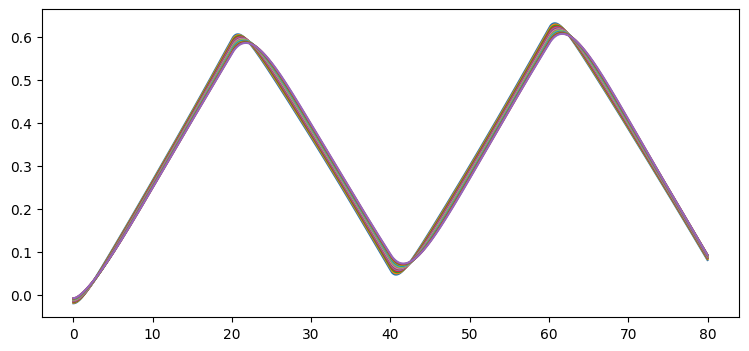

In [16]:
fig,ax=plt.subplots()

for _, itteration in interrations.items():
    
    error = (itteration['x'][:,0] - ys)
    itteration['rms'] = np.mean(error**2)
    ax.plot(time, itteration['x'][:,0])

    
    

In [17]:
rms = [interration['rms'] for _,interration in interrations.items()]

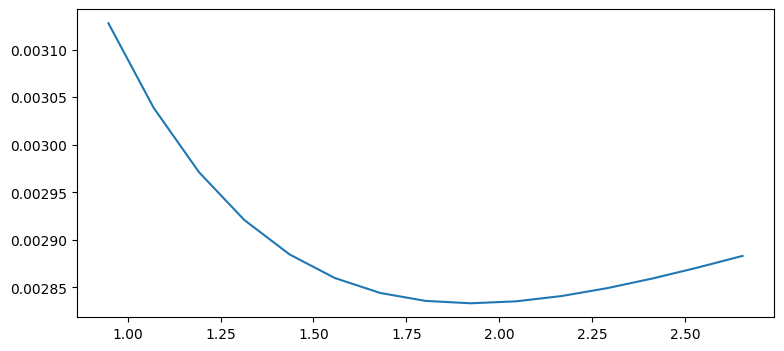

In [18]:
fig,ax=plt.subplots()
ax.plot(T_1s, rms);

In [19]:
from scipy.optimize import least_squares

In [20]:
def fun(x):
    
    T_1_ = x[0]
    K = x[1]
    
    Ad = np.array([[1, h], 
               [0, 1 - h / T_1_]])
    Bd = np.array([[0, -K * h / T_1_]]).T
    
    x_hat,P = filter(Ad=Ad, Bd=Bd)
    
    error = (x_hat[:,0] - ys)
    rms = np.mean(error**2)
    return rms
    

In [ ]:
T_1_ = res.x[0]
K_ = res.x[1]

Ad = np.array([[1, h], 
               [0, 1 - h / T_1_]])
Bd = np.array([[0, -K_ * h / T_1_]]).T
    
x_hat,P = filter(Ad=Ad, Bd=Bd)

In [ ]:
fig,axes=plt.subplots(nrows=2)
keys = ["psi_deg", "r_deg"]
for i, key in enumerate(keys):

    ax = axes[i]
    df.plot(y=key, ax=ax, label="True")
    
    if key == "psi":
        df.plot(y="psi_measure_deg", ax=ax, label="Measured", zorder=-1)

    ax.plot(time, np.rad2deg(x_hat[:, i]), "-", label="rts smoother")
    ax.set_ylabel(key)
    ax.legend(loc='upper right')